In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.measure import regionprops, label
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects

In [2]:
data = tifffile.imread('data/demoMovie.tif')
movie = (data - data.min(axis=(1, 2), keepdims=True)) / (np.ptp(data, axis=(1,2), keepdims=True))
roi = np.load('data/to_split.npy')
roi_full = roi.copy()
proj = movie.max(axis=0)

In [3]:
mask = label(roi)
props = regionprops(mask)

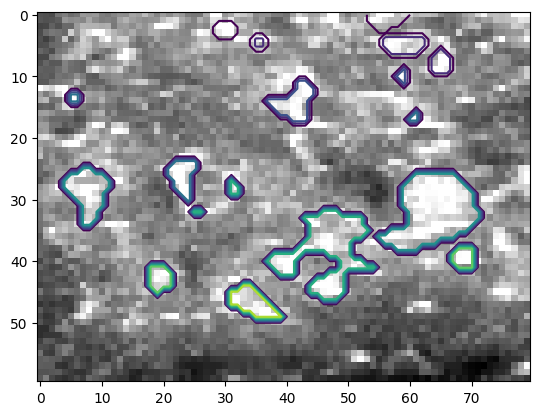

In [4]:
plt.imshow(proj, cmap='gray')
plt.contour(roi)

## ROI Splitting  

This module introduces the process of subdividing ROIs that may encompass more than one neuron. As imaging resolution and signal complexity increase, it becomes more common for automated methods to group nearby neurons into a single ROI. In this module, we will learn how to recognize these cases, enhance local structure, and split such ROIs into distinct neuronal units.

### **Identifying ROIs that need splitting**


First we need to know which label refers to which roi. 


Use `label2rgb` to plot each component in different color.

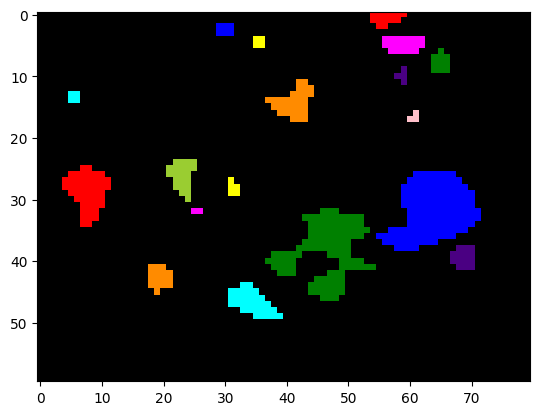

In [5]:
overlay = label2rgb(mask, bg_label=0)
plt.imshow(overlay, cmap="gray")

The easiest way to identify ROIs that need splitting is through simple visual examination. Typically, they appear as irregular shaped masks.

**Example** Plot ROI 16

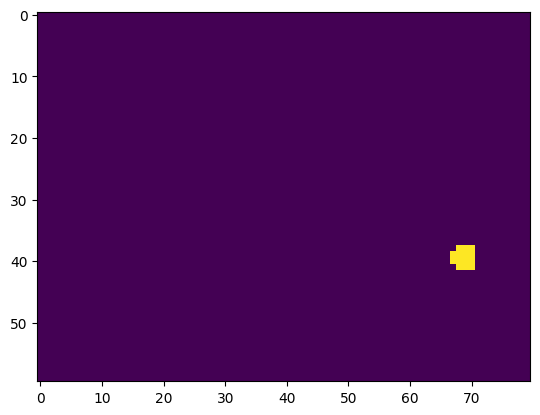

In [6]:
roi = mask == 16
plt.imshow(roi)

**Exercise** Plot ROI 11

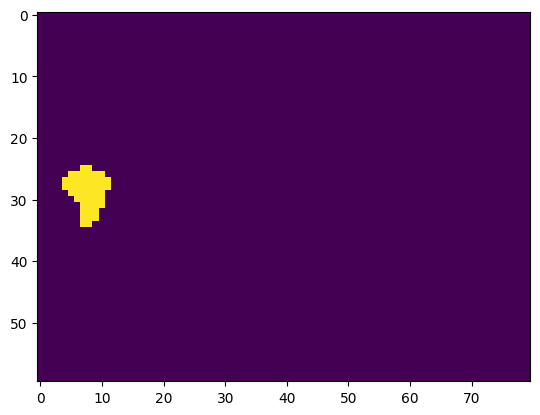

In [7]:
roi = mask == 11
plt.imshow(roi)

Plot ROI 12

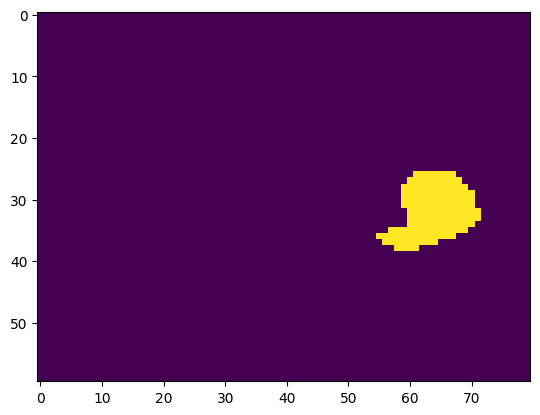

In [8]:
roi = mask == 12
plt.imshow(roi)

Another way is to examine their eccentricities. Circular shaped ROIs have eccentricity close to zero whereas irregular shaped ones are closer to 1.

**Example** What is the eccentricity of ROI 16?

In [9]:
props[15].eccentricity

0.2036532699906393

What is the eccentricity of ROI 11?

In [10]:
props[10].eccentricity

0.7004667125210006

What is the eccentricity of ROI 12?

In [11]:
props[11].eccentricity

0.673428196012261

Another way is to see how many local intensity peaks are within the component.

**Example** How many local intensity peaks are in roi 16?

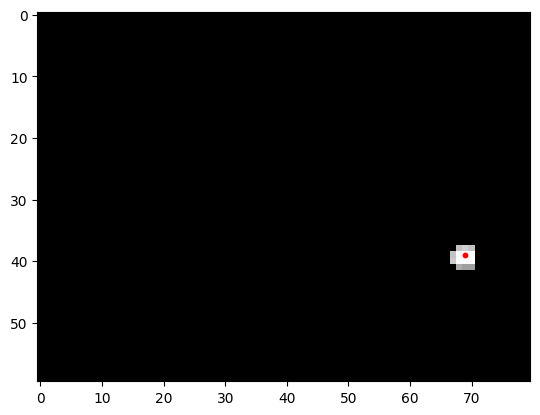

In [12]:
roi = mask == 16
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

How many local intensity peaks are in roi 11?

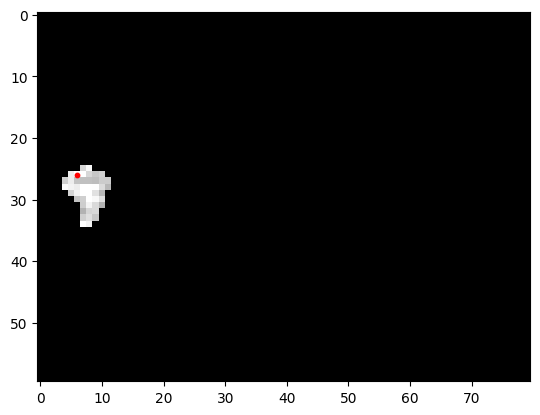

In [13]:
roi = mask == 11
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

How many local intensity peaks are in roi 12?

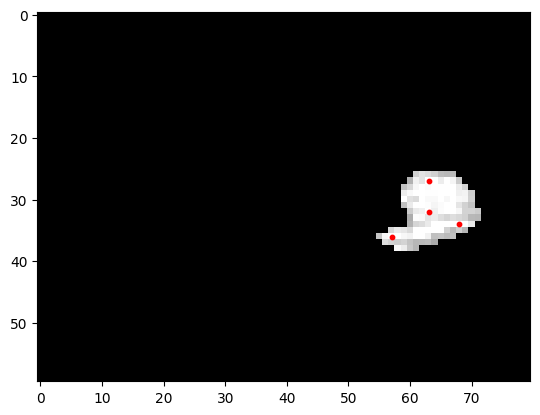

In [14]:
roi = mask == 12
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

### Enhancing ROI Detail Through Local Filtering  

In order to distinguish overlapping or closely located neuron signals, it is helpful to enhance the internal structure of the ROI. This section introduces image processing techniques such as adaptive histogram equalization and Laplacian of Gaussian filtering. These methods help reveal subtle features and boundaries that are essential for accurate sub-segmentation.

Let us use ROI 12

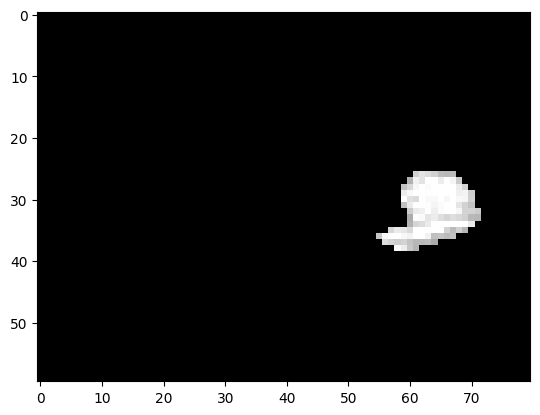

In [15]:
roi = mask == 12
roi_crop = proj * roi
coords = peak_local_max(roi_crop, min_distance=5)
plt.imshow(roi_crop, cmap='gray')

One way to enhance the image is through gamma correction which adjusts the brightness of the image. Image is brightened when `gamma < 1` and darkened when `gamma > 1`.

**Example** Brighten the image with `gamma = 0.5`.

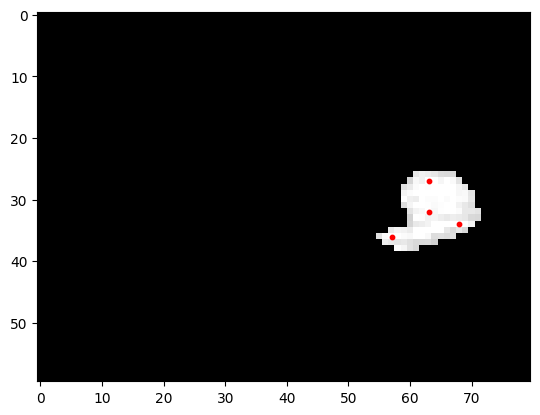

In [16]:
gamma_corrected = adjust_gamma(roi_crop, gamma=0.5)
plt.imshow(gamma_corrected, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

Set `gamma = 0`.

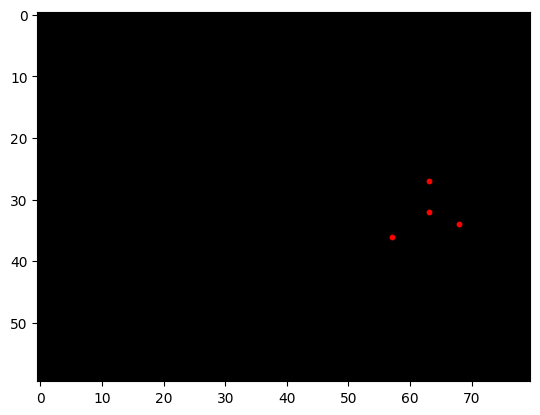

In [17]:
gamma_corrected = adjust_gamma(roi_crop, gamma=0.0)
plt.imshow(gamma_corrected, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

Set `gamma = 2.0`.

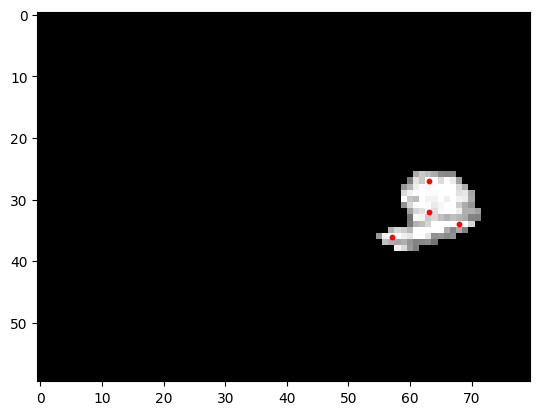

In [18]:
gamma_corrected = adjust_gamma(roi_crop, gamma=2.0)
plt.imshow(gamma_corrected, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

We can also use adaptive histogram equalization to enhance small variations. The parameter `clip_limit` controls how aggressive the enhancement is.

**Example** Use adaptive histogram equalization with clip_limit set to 0.4

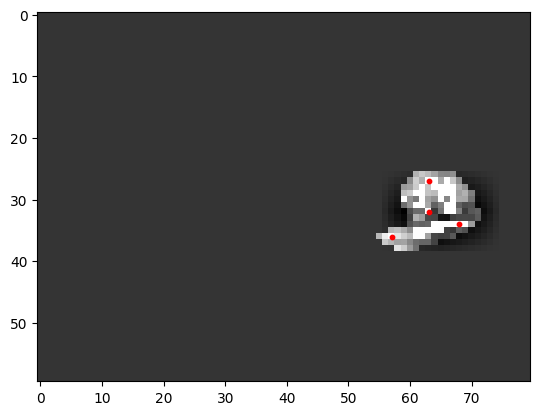

In [19]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.4)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

Use adaptive histogram equalization with clip_limit set to 0.1

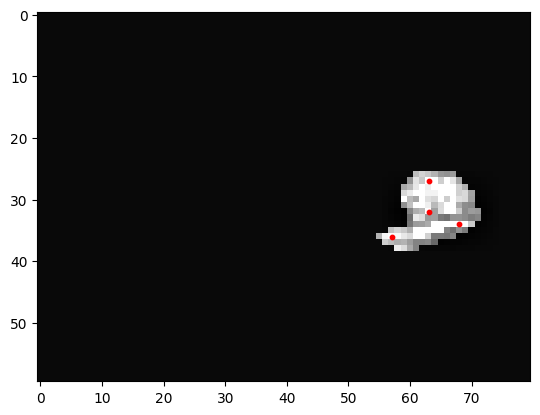

In [20]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=0.1)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

Use adaptive histogram equalization with clip_limit set to 1.0

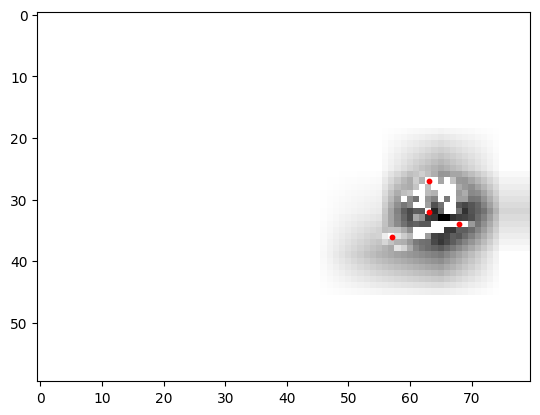

In [21]:
roi_crop_norm = roi_crop / roi_crop.max()
enhanced = equalize_adapthist(roi_crop_norm, clip_limit=1.0)
plt.imshow(enhanced, cmap='gray')
plt.scatter(coords[:, 1], coords[:, 0], s=10, c='r')

### **Segmenting sub-regions using Watershed**

The watershed algorithm is a technique that treats the image like a topographic surface, where pixel intensity represents elevation. It "floods" the image from marked points (called markers), and boundaries (edges) are determined by the "watershed lines" where the flooding from different markers meets.

The watershed algorithm uses markers to start the flooding process and a distance map to guide the flow. A distance map is an image where each pixel represents the distance from that pixel to the nearest background pixel

**Example** Create labeled markers from local peak coordinates.

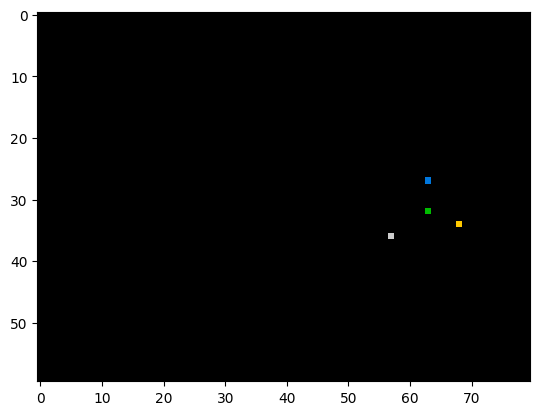

In [22]:
markers = np.zeros_like(roi_crop, dtype=np.int32)
for i, (y, x) in enumerate(coords):
    markers[y, x] = i + 1
plt.imshow(markers, cmap='nipy_spectral')

Distance map/matrix is not a segmentation result by itself but a preparatory step to guide algorithms (like watershed) to segment regions based on distances. This map helps determine the flooding direction. It floods from the regions with the highest distance (farthest from the boundary), so areas far from the boundary are filled first. As the "flood" progresses, it meets other regions or different markers. Where these floods meet, watershed lines are drawn, segmenting the image into distinct regions.

The negative distance is used because the watershed algorithm floods from the lowest points (boundary) to the highest points (center).

**Example** Create distance matrix for `roi_crop`.

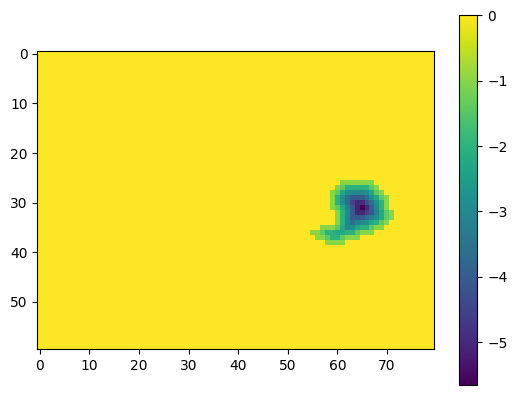

In [23]:
distance = ndi.distance_transform_edt(roi_crop)
plt.imshow(-distance)
plt.colorbar()

Create distance matrix for `roi_norm`.

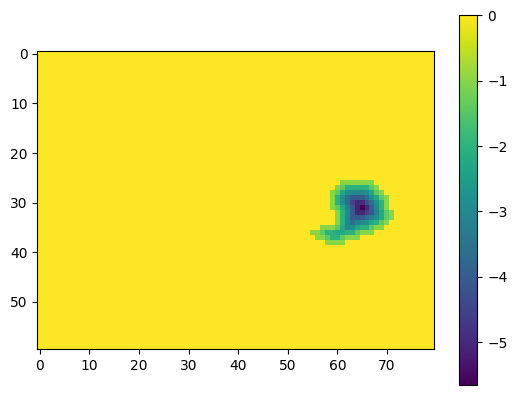

In [24]:
distance = ndi.distance_transform_edt(roi_crop_norm)
plt.imshow(-distance)
plt.colorbar()

Create distance matrix for `enhanced`.

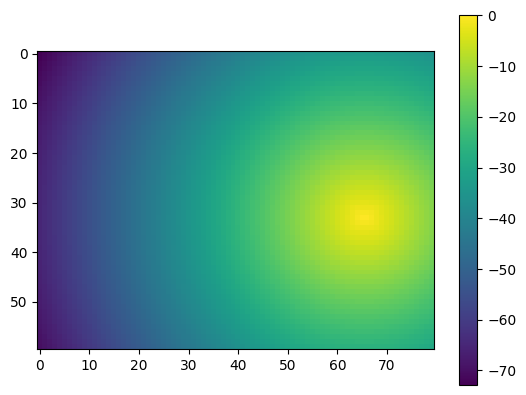

In [25]:
distance = ndi.distance_transform_edt(enhanced)
plt.imshow(-distance)
plt.colorbar()

**Example** Apply watershed using our markers and distance matrix for `roi_crop`.

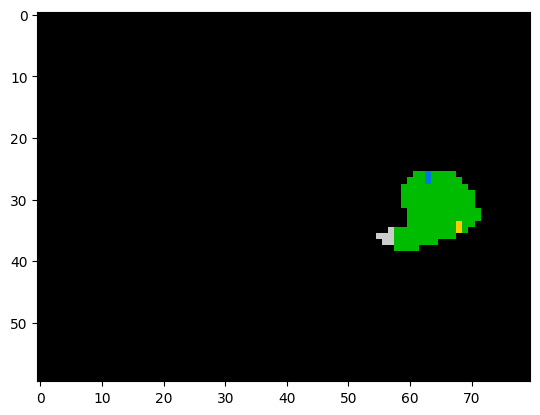

In [26]:
distance = ndi.distance_transform_edt(roi_crop)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")

Apply watershed using our markers and distance matrix for `roi_crop_norm`.

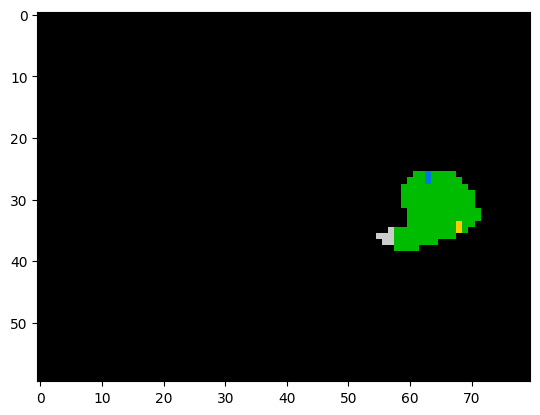

In [27]:
distance = ndi.distance_transform_edt(roi_crop_norm)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")

Apply watershed using our markers and distance matrix for `enhanced`.

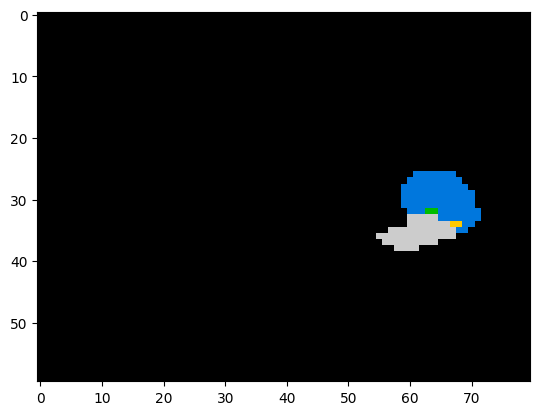

In [28]:
distance = ndi.distance_transform_edt(enhanced)
labels = watershed(-distance, markers, mask=roi)
plt.imshow(labels, cmap="nipy_spectral")

### **(DEMO)** Removing and/or Merging Oversegmented ROIs

There is an oversegmentation here. Remove small objects from the labels

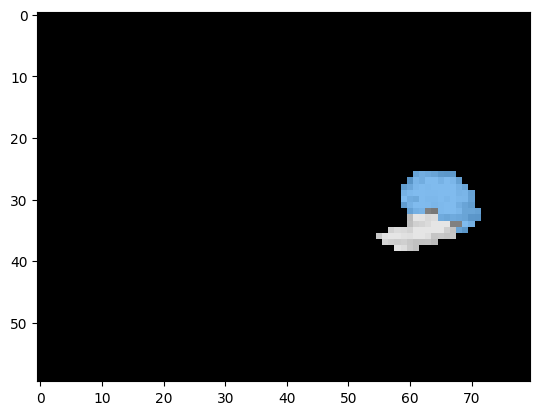

In [29]:
cleaned = remove_small_objects(labels, min_size=4)
plt.imshow(roi_crop, cmap="gray")
plt.imshow(cleaned, cmap='nipy_spectral', alpha=0.5)

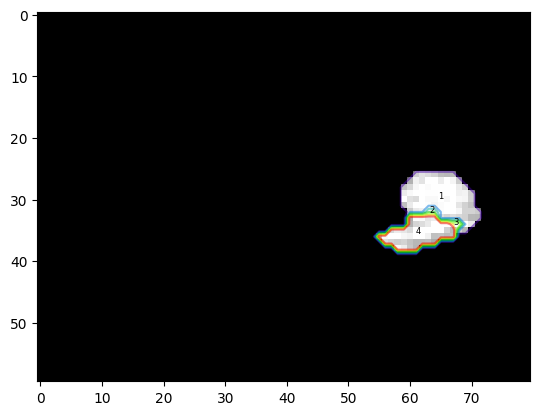

In [30]:
plt.imshow(roi_crop, cmap="gray")
plt.contour(labels, cmap="nipy_spectral", alpha=0.5)
for region in regionprops(labels):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')

**Exercise** Merge 2 and 3 with 1.

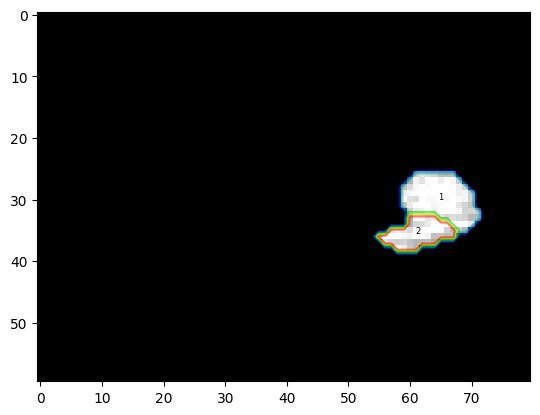

In [31]:
props = regionprops(labels)
merged = np.copy(labels)
merged[merged == 2] = 1
merged[merged == 3] = 1
merged[merged == 4] = 2

plt.imshow(roi_crop, cmap="gray")
plt.contour(merged, cmap="nipy_spectral", alpha=0.5)
for region in regionprops(merged):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')


Updating full ROI list with split roi

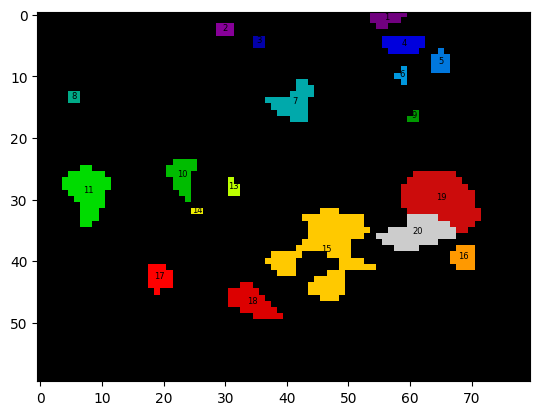

In [32]:
updated_mask = roi_full.copy()
updated_mask[updated_mask == 12] = 0
labels_shift = merged + updated_mask.max()
updated_mask[roi > 0] = labels_shift[roi > 0]

plt.imshow(updated_mask, cmap='nipy_spectral')
for region in regionprops(updated_mask):
    y, x = region.centroid
    plt.text(x, y, str(region.label), color='black', fontsize=6, ha='center')
